In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import itertools as it
from collections import Counter, defaultdict, deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from agents import Agent
from mouselab_utils import *
from joblib import load

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
from glob import glob
import re
from utils import Labeler
labeler = Labeler()

def load_rollouts():
    for f in glob('data/rollouts/constant_high_1_*.pkl'):
        d = load(f)
        d['phi'] = list(d['phi'])
        df = pd.DataFrame(d)
        seed = re.search('(\d+)\.pkl', f).group(1)
        df['env_seed'] = seed
        df['env_i'] = seed + '-' + df.env_i.astype(str)
        df['state'] = df.s
        df.s = df.s.apply(labeler)
        yield df

data = pd.concat(load_rollouts())
df = data.query('a != 17')

In [80]:
assert data.query('a == 17').groupby(['env_i', 's']).q.std().max() == 0

In [81]:
idx = df.groupby(['s', 'a']).apply(len) >= 30
tdf = df.set_index(['s', 'a']).loc[idx].reset_index()
print(f'{idx.sum()} test pointts')

2163 test pointts


In [82]:
g = tdf.groupby(['s', 'a'])
Xt = np.stack(g.phi.apply(lambda x: x.iloc[0]))
yt = g.q.mean().as_matrix()

In [84]:
from sklearn.linear_model import LinearRegression

X = np.stack(df['phi'])
y = np.array(df['q'])
model = LinearRegression().fit(X, y)
print(model.intercept_, model.coef_.round(3))
print(model.score(Xt, yt))

15.0390286764 [ 0.     0.     0.501 -0.806  0.586]
0.0606215161432


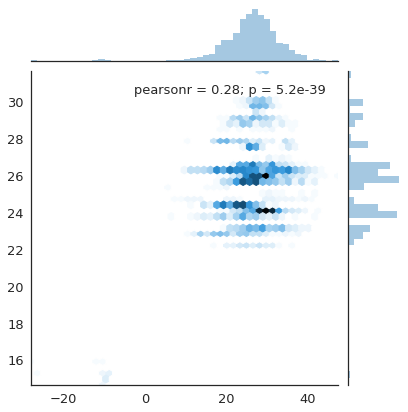

In [85]:
yhat = model.predict(Xt)
sns.jointplot(yt, yhat, kind='hex')